In [1]:
if 'google.colab' in str(get_ipython()):
  %pip install pycocotools omrdatasettools xmlschema > /dev/null
  %pip install torchvision --upgrade > /dev/null


In [1]:
from omrdatasettools import Downloader, OmrDataset
import xmlschema

import os
import glob
import re
from PIL import Image
from lxml import etree
from pprint import pprint
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from datasets import MuscimaObjects, MuscimaDownloader

In [2]:
muscimaroot = MuscimaDownloader.download()

dataset = MuscimaObjects.MuscimaObjects(muscimaroot)

Extracting MuscimaPlusPlus_V2 dataset...
Deleting temporary directory /scratch/users/cakarsubasi18/JupyterWorkspace/omrtorch/MuscimaPpImages
Extracting MuscimaPlusPlus_MeasureAnnotations dataset...


### Model

In [3]:
from visionutils.engine import train_one_epoch, evaluate
import visionutils.utils as utils
import visionutils.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Initialized module


In [4]:
dataset = MuscimaObjects.MuscimaObjects(muscimaroot, transforms=get_transform(train=True))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

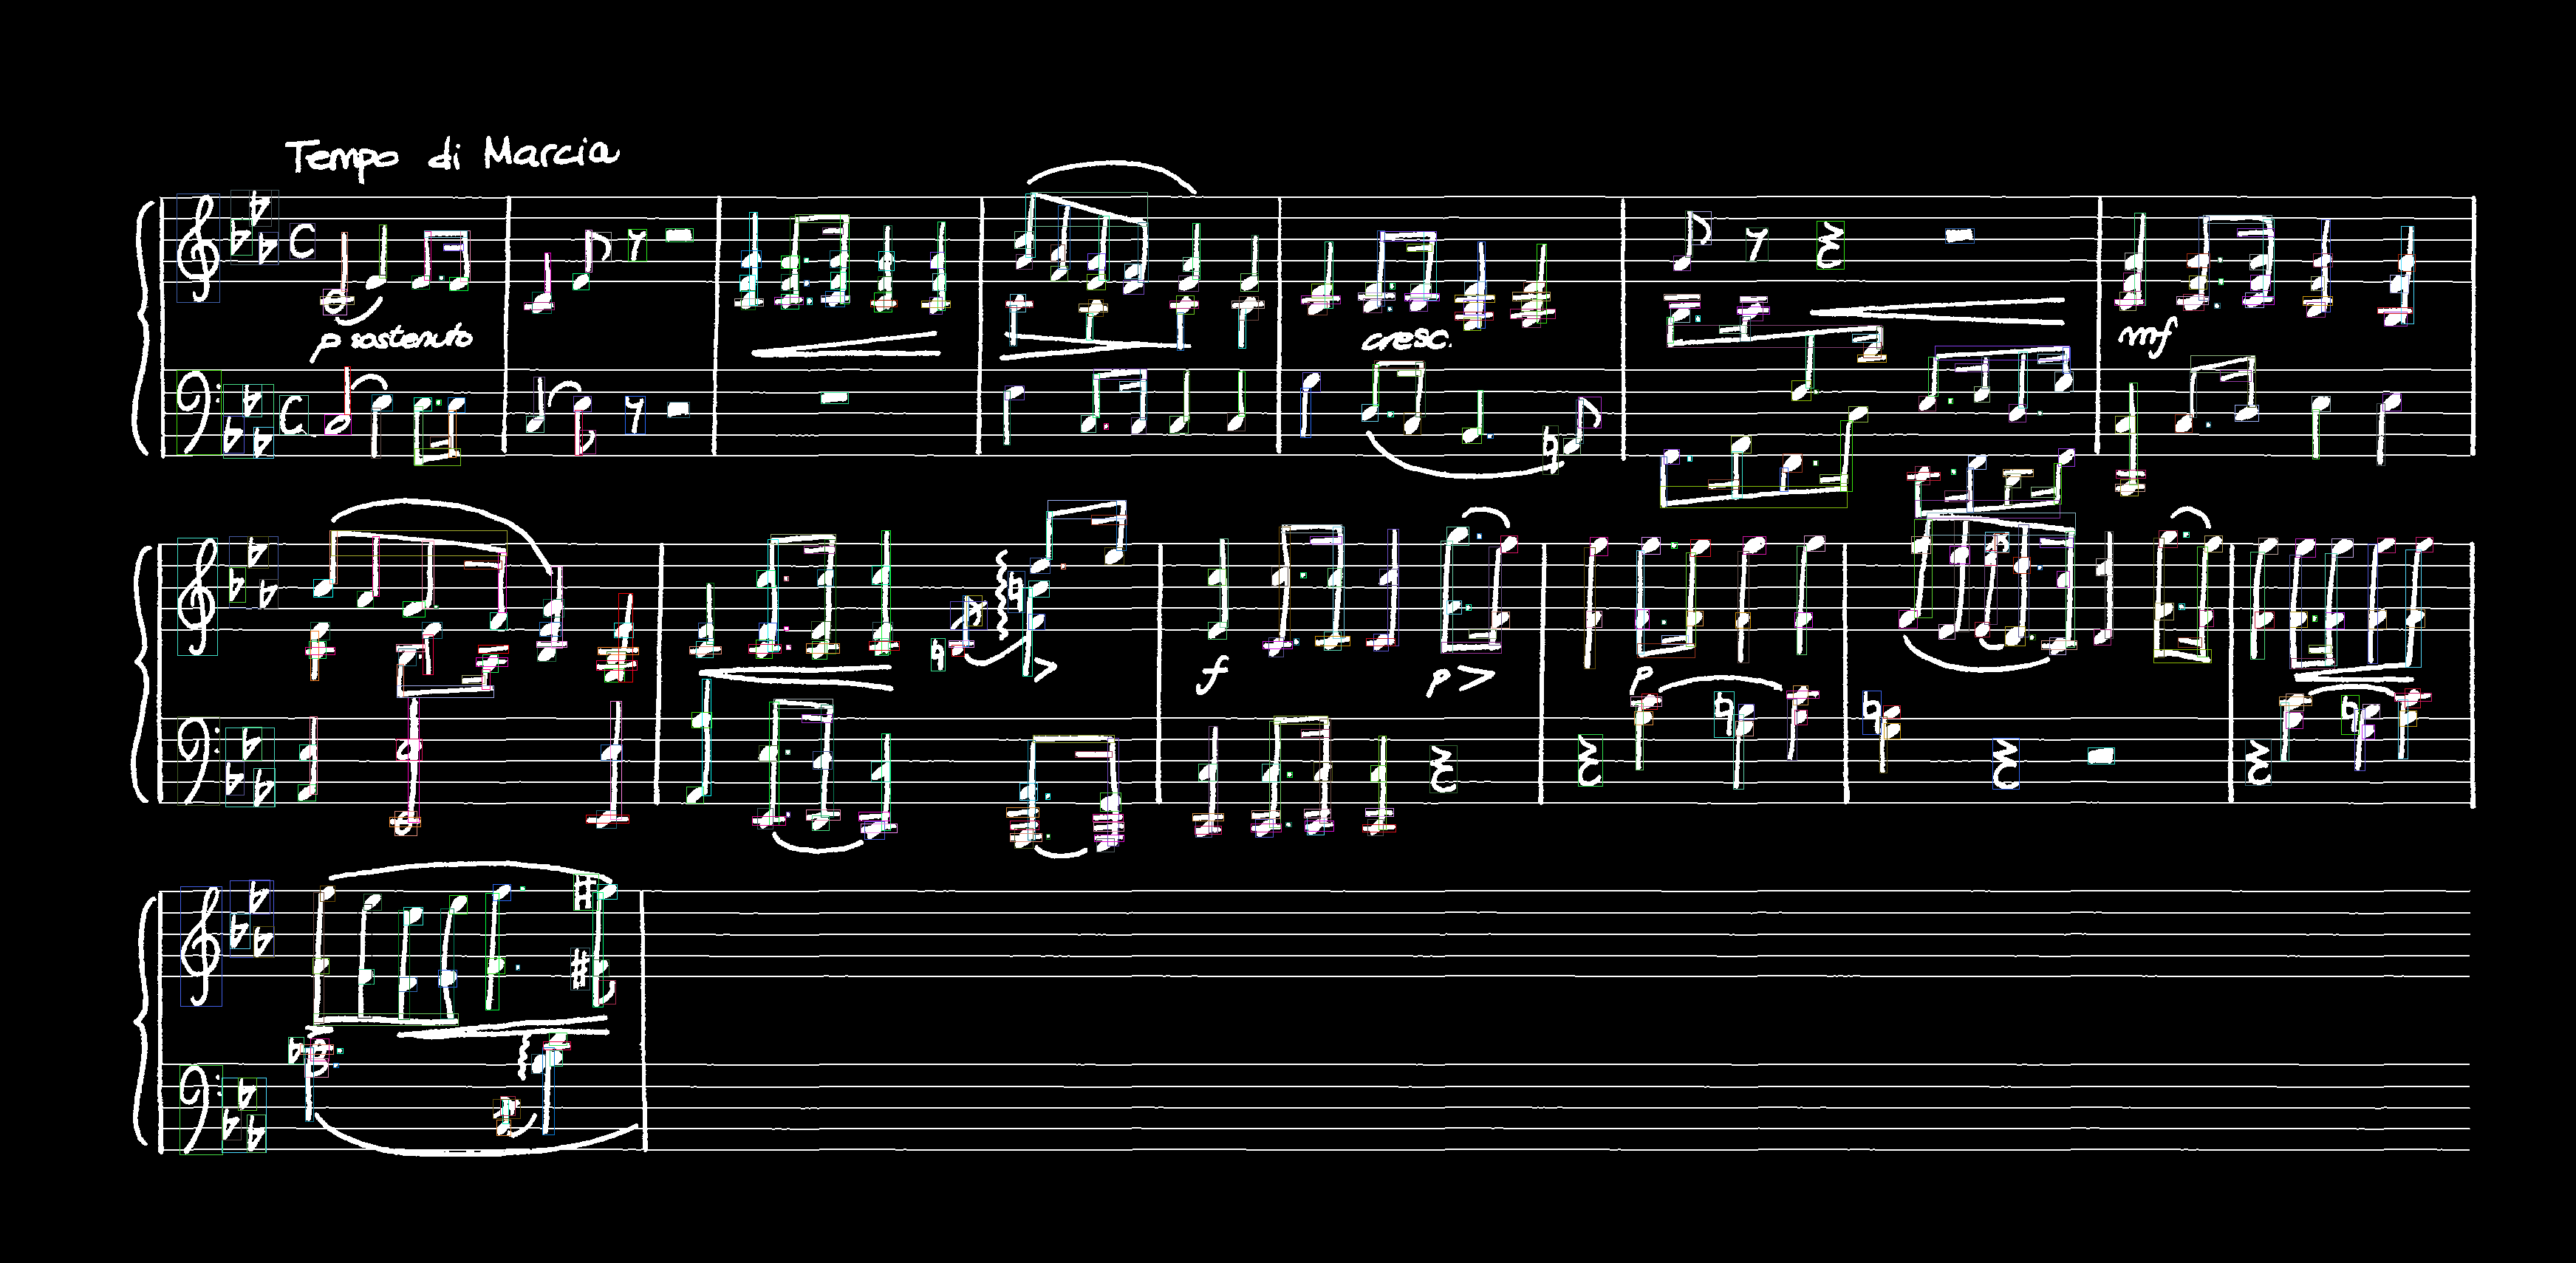

In [5]:
sample_im, sample_ann = dataset[0]
sample_boxes = sample_ann['boxes']

sample_im = (255*sample_im).type(torch.ByteTensor)

from torchvision.utils import draw_bounding_boxes


sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes)

sample_im_with_bounding_boxes.shape
Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

### Model

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.anchor_utils import AnchorGenerator

# Pretrained model
# [0.12, 0.24, 0.91, 4.97] - standard reduced symbols
# [0.34, 0.6, 0.88, 1.21] - pitch info only
def get_faster_rcnn_with_n_classes(n: int):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=1)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.detections_per_img = 400

  aspects = (0.38, 0.75, 1.14)
  anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
  aspect_ratios = (aspects,) * len(anchor_sizes)
  rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

  model.rpn.anchor_generator = rpn_anchor_generator

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n)

  return model

In [7]:
from datasets import models
#aspects = (0.12, 0.24, 0.91, 4.97)

#model = models.muscima_fpn_model(
#    len(dataset.label_list) + 1,
#    backbone='resnet50',
#    aspects=aspects)

In [7]:
label_list_pitch_only = ['noteheadFull', 'noteheadHalf', 'noteheadWhole', 'accidentalSharp', 'accidentalFlat', 'accidentalNatural',
                    'gCflef', 'fClef', 'cClef']

model = get_faster_rcnn_with_n_classes(len(label_list_pitch_only) + 1)

In [8]:
# Test

images, targets = next(iter(dataloader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output = model(images, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

In [10]:
dataset = MuscimaObjects.MuscimaObjects(muscimaroot, label_list_pitch_only, transforms=get_transform(train=True))
dataset_test = MuscimaObjects.MuscimaObjects(muscimaroot, label_list_pitch_only, transforms=get_transform(train=False))

#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

print(len(dataset))
print(len(dataset_test))

#dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

100
40


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)

# learning rate 10x reduction every three epocs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [12]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 3

run_training_and_validation = True

if run_training_and_validation:
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/50]  eta: 0:06:23  lr: 0.000021  loss: 10.1076 (10.1076)  loss_classifier: 2.6608 (2.6608)  loss_box_reg: 0.4898 (0.4898)  loss_objectness: 5.9139 (5.9139)  loss_rpn_box_reg: 1.0431 (1.0431)  time: 7.6778  data: 1.4180  max mem: 2595
Epoch: [0]  [10/50]  eta: 0:01:34  lr: 0.000225  loss: 2.9558 (4.6837)  loss_classifier: 1.1744 (1.4981)  loss_box_reg: 0.3047 (0.3292)  loss_objectness: 0.6487 (1.9764)  loss_rpn_box_reg: 0.9351 (0.8800)  time: 2.3668  data: 1.1448  max mem: 4249
Epoch: [0]  [20/50]  eta: 0:01:00  lr: 0.000429  loss: 1.7722 (3.1613)  loss_classifier: 0.6373 (1.0385)  loss_box_reg: 0.3667 (0.3728)  loss_objectness: 0.3032 (1.1196)  loss_rpn_box_reg: 0.4185 (0.6304)  time: 1.7416  data: 1.0628  max mem: 4249
Epoch: [0]  [30/50]  eta: 0:00:39  lr: 0.000633  loss: 1.4613 (2.6231)  loss_classifier: 0.5508 (0.8800)  loss_box_reg: 0.4127 (0.3885)  loss_objectness: 0.1496 (0.8064)  loss_rpn_box_reg: 0.3400 (0.5481)  time: 1.7271  data: 1.0681  max mem: 4258
Epoch:

In [16]:
# Since the outputs stop updating when the Jupyter Kernel disconnects, run evaluation one more time
# to print results
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/40]  eta: 0:00:25  model_time: 0.1312 (0.1312)  evaluator_time: 0.2289 (0.2289)  time: 0.6442  data: 0.2799  max mem: 4538
Test:  [39/40]  eta: 0:00:00  model_time: 0.1035 (0.1029)  evaluator_time: 0.3011 (0.2899)  time: 0.6946  data: 0.2862  max mem: 4538
Test: Total time: 0:00:27 (0.6897 s / it)
Averaged stats: model_time: 0.1035 (0.1029)  evaluator_time: 0.3011 (0.2899)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

###Visualization

In [13]:
def visualize_bboxes(image, target, labels=None, threshold=0.5):
    colors = ['000000', 'red', 'blue', 'green', 'yellow']
    sample_boxes = target['boxes']
    sample_scores = target['scores']
    sample_labels = target['labels']
    idx = torch.where(sample_scores > threshold)
    boxes_sliced = sample_boxes[idx]
    labels_sliced = sample_labels[idx].tolist()
    labels_list_str = None
    if labels is not None:
        labels_list_str = list(labels[val] for val in labels_sliced)
        colors_list = list(colors[val] for val in labels_sliced)
    sample_image = (image*255).type(torch.ByteTensor)

    sample_im_with_bounding_boxes = draw_bounding_boxes(sample_image, boxes_sliced, colors='red', width=3, font_size=32)

    return Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))


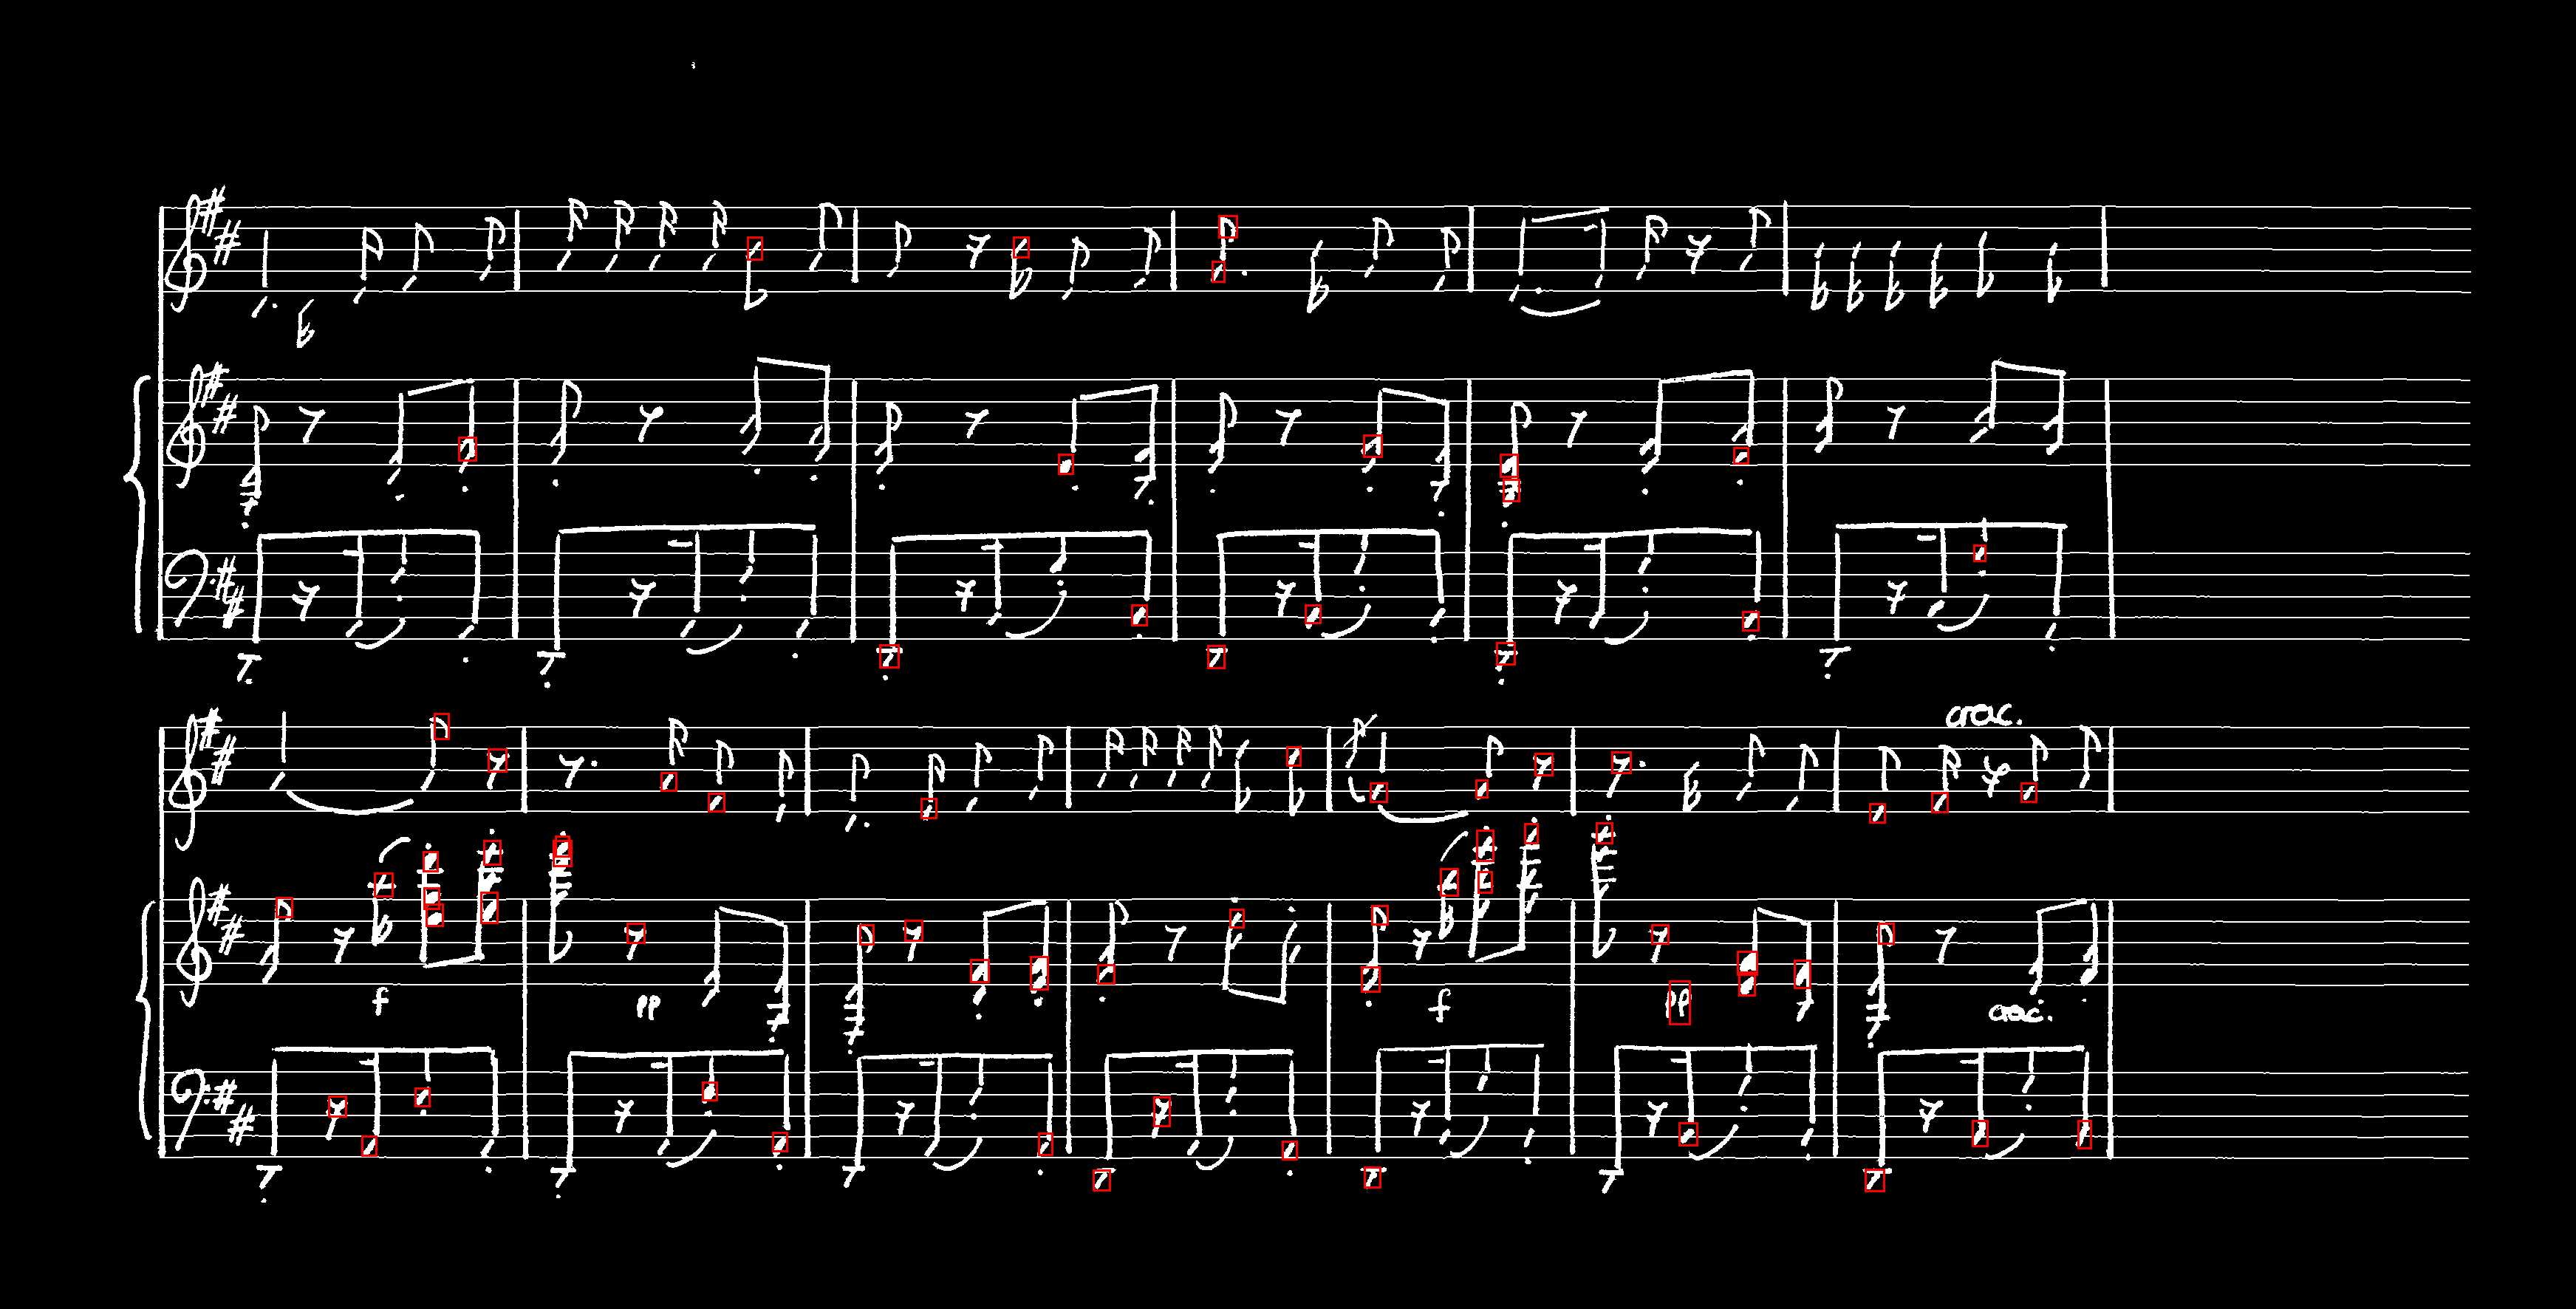

In [17]:
image_index = 1

model.eval()
if torch.cuda.is_available():
  torch.cuda.synchronize()
hacky_dataset = list(iter(data_loader_test))
#image = list(img.to(torch.device('cuda')) for img in image)
image, target = hacky_dataset[image_index]
image = list(img.to(torch.device('cuda')) for img in image)
detections = model(image)

#model.eval()
#if torch.cuda.is_available():
#  torch.cuda.synchronize()
#image, target = next(iter(data_loader_test))
#image = list(img.to(torch.device('cuda')) for img in image)
#detections = model(image)
visualize_bboxes(image[0], detections[0], threshold=0.5)

In [14]:
detections[0]['boxes'].shape
#torch.sum(detections[0]['labels']==1)

torch.Size([106, 4])

In [17]:
# Example save everything
SAVE_ENTIRE_MODEL = "muscima_objects_0146.pt"

torch.save(model, SAVE_ENTIRE_MODEL)

In [ ]:
# 15 epochs, Adam, lr=0.001, *0.1 every 5 epochs, 0.135 mAP with custom aspect ratios
# 15 epochs, Adam, lr=0.001, *0.1 every 5 epochs, 0.113 mAP with default aspect ratios
# 50 epochs, Adam, Lr=0.001, *0.1 every 10 epochs, 0.146 mAP with custom aspect ratios